<p style="text-align: center; font-size:2.5em; font-weight: bold;">Final Project </p><br>


<div style='border:1px #D0D0D0 solid; border-radius: 10px; padding:0px 10px 10px; font-family: Georgia, serif'>
<h1>1. Motivation</h1>
<p>In our video we explained how we wanted to provide a report for users to find the best businesses in a city by looking at how satisfied were their customers. To do this, we needed to analyse the reviews of these businesses looking for something else than start rating, namely, performing a sentiment analysis.</p>

<h3> 1.1 What is your dataset?</h3>

<p>As mentioned in the video, we had to face a huge amount of <a href="https://www.yelp.com/dataset/download" target="_blank">data</a> (approximately 8GB). However, not all of it was relevant to achieve the goal of our project. So we defined some criteria to select the most relevant data for us. Finally, we gathered this data in three different JSON files:
    <li style="margin:5px 0px 0px 20px;"><i>business.json</i>: contains information of the 123374 businesses that are still active including location, attributes, and categories.</li>
<li style="margin:5px 0px 0px 20px;"><i>review.json</i>: with the full reviews from customers including the user_id from the customer who wrote the review and the business_id of the business which received the review. In total, 376563 reviews, removing those considered unrelevant because they were writen before 2017.</li>
    <li style="margin:5px 0px 0px 20px;"><i>user.json</i>: picking the 'elite' users (a distinction within yelp's platform) and keeping the active ones during 2017, we got detailed information of 92 users, i.e. friend mapping, number of fans and review count. Initially, appears to be a small number, but through these fields we can reveal information from more than 60000 users such as social connections.</li></p>

<h3> 1.2 Why did you choose this/these particular dataset(s)? </h3>

<p>Since we were looking for customers' reviews on different businesses, we looked into one of the best known platforms that provide this service: <a href="https://www.yelp.com/dataset/download" target="_blank">Yelp!</a>. For obvious reasons we couln't access their whole database. Nevertheless, Yelp offers a limited dataset for students, with businesses from a selection of cities, so we can practice our skills as data scientists.</p>

<h3> 1.3 What was your goal for the end user's experience? </h3>

<p>The goal of our project is to provide users with a rank of business according to the sentiment on reviews rather than "stars". A customer can grade a business by fastly giving it a certain amount of stars without thinking of the whole customer experience received in that business. However, writing a review takes some time, customers explain their experience and reflect their feeling on the text. That is why we analyze those reviews, to conclude with a "happiness grade" for businesses that users can find more valuable.</p>
</div>

<div style="border:1px #D0D0D0 solid; border-radius: 10px; padding:0px 10px 10px;font-family: Georgia, serif">
<h1> 2. Basic stats. Let's understand the dataset better</h1>
<h3> 2.1 Write about your choices in data cleaning and preprocessing</h3>

<p>Given such a large dataset we needed to be very careful when filtering to avoid losing relevant information while notably reducing the amount of data involved in our analysis.<p>

<p>The first criterion we followed was time: dividing the activity in Yelp by years. This approach allowed us to provide users with a comprehensive view of progress over time.</p>

<p>We defined criteria for relevance looking for proof-of-trust in the platform, that apply differently for users and for businesses:
    <li style="margin:5px 0px 0px 20px;"> <i>Business</i>: We chose only to consider the businesses that have a number of reviews between 100 and 300 (for a matter of relevance and time-consumption). Then we chose to establish a link between two businesses if one same elite user has posted a review about both of them.</li>
    <li style="margin:5px 0px 0px 20px;"> <i>Users</i>: First, we filtered the elite users, which <a href='https://www.yelp-support.com/article/What-is-Yelps-Elite-Squad?l=en_US' target="_blank">according to Yelp</a>, are rewarded for being active and for being role models. This selection was not enough to for us, because it kept some users with very little influence in the platform, thus we only selected users followed by more than 10 fans (we consider it a minimum level of acceptance within the Yelp community), and a minimum count of 50 reviews, to avoid the least active users.</li></p>


<h3>2.2 Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)</h3>
</div>



<div style="border:1px #D0D0D0 solid; border-radius: 10px; padding:0px 10px 10px; font-family: Georgia, serif">
<h1> 3. Tools, theory and analysis. Describe the process of theory to insight </h1>

<h3> 3.1. Preprocessing and data parsing. </h3>

<p>The vast dimensions of the dataset have lead us to use new tools in order to filter and to parse the collected data. To do so, we have used the Spark Python API (PySpark) which is a fast and general engine for large-scale data processing. Thanks to it we have been able to reduce the files' size regarding relevant filters. </p>

<p> In fact, we have used the PySpark dataframe's structure, which is similar to the Pandas' one. Even if this is a really powerfull, we have been struggling using PySpark since errors leads to hundred of lines. The interesting and powerfull part of it is that you can create fictive SQL table from a dataframe and then apply SQL queries. This was really convenient to filter the large files that we downloaded.</p>

<p> We have mostly used PySpark to work with users and reviews. The untreated version of the reviews.json was 4.72GB. We first made the choice to work on only with the reviews of opened businesses, which lead us to a 4.02GB file. Then we had to tune our filter criterion to end up with "workable" file. We then decided to remove all the reviews posted before 2017 and to keep only the ones on businesses that have between 100 and 300 comments. So that they have a significant number of remarks. Regarding the users, we filtered them to get the most influent of them, as described in the above section.</p>

<p>For some deeper analyzis we had to work on comments about businesses from a same category. To do so, we had to make jointures between the review dataframe and the business one. Once again PySpark showed itself to be very powerfull and fast.</p>

<p> After all of these filtering processes we stored our data as <i>.json</i> files. For an undetermined reason files were split into small <i>.json</i> files in a same folder.</p>



<h3> 3.2. Comments analyzis </h3>

<p>As described before the aim of our project was to rank businesses regarding the comments users' posted. To do so, a major part of our work was to analyze those comments. Our idea was to create a ranking system according to the happiness of users' comments. To our mind this might be more significant since it is difficult for someone to evaluate an experience with a number of stars.</p>

<p>With this aim in mind we have used the <i>NLTK</i> library and worked with a file attributing a happiness mark to every words. Then have computed the mean value of this mark for every comments. This is exactly the same process that we have used for the last assignment. We have also used the <i>TFIDF</i> statistic in order to draw <i>WordClouds</i> to identify the most used words in comments.</p>

<p>By plotting the distribution came out that the marks range was not really extensive (lowest mark was around 3.2 and the highest one 4.35 ish) and most of them where gathered around 3.8. In order to analyze it and to compare it to the Yelp ranking system we have expanded the the interval to get values values from 0 to 5. As you can observe <a href="#diff_marks">here</a> our grades can be really different from the stars' ones. !!!!DEEPER EXPLAINATION!!!!<p>
    
<p> Then we wanted to analyze the different feelings of people according to the business category. Since Yelp lists a lot of different categories we made the choice to work with the 10 categories with the highest number of comments. As you can observe <a href="#diff_categories">here</a> the distribution has always the shape of a normal distribution but the mean value is different and the peak's width is also varying. As we can observe, the business category which makes people happiest is 'Restaurants', which is also the one with the highest number of comments. </p>

<p> We then had the will to pinpoint the different most used words within categories. In the notebook we made the choice to only plot one <i>WordCloud</i> for a matter of readability, but you can see the different plots <a href="http://www.student.dtu.dk/~s182291/Website/sentiments.html#wordclouds" target="_blank">here</a>. The most used words are always the same: "great", "good", "like" ,... We can see a distinction between categories that are related 
to food and with those that are not.

<h3> 3.3. Networks </h3>

<h3> 3.4. Map </h3>
<p>The last work we made, which is more superfluous than the other one, is to display some informations on a map. Since the set up to use librairies presenting that feature are really complicated we did not manage to run it on a Jupyter Notebook but you can find the find one result <a href="#map">here</a> and the Python file <a href="http://www.student.dtu.dk/~s182291/Python_files/mapVisualization.py" target="_blank">here</a>. In the map section of this notebook we decided to focus on the city of Phoenix because it gathered the more data. We have plotted every businesses on the map at their own location. Then according to the their happiness mark we have given them a color going from red to green. </p>

</div>

<div style="border:1px #D0D0D0 solid; border-radius: 10px; padding:0px 10px 10px; font-family: Georgia, serif">
<h1> 4. Discussion. Think critically about your creation </h1>
<h3> 4.1 What went well?</h3>

<p>We struggled to begin working with this dataset because we did not expect such a large amount of data. However, we managed to filter appropreatly so we were able to extract relevant information while keeping the amount of data in a range we could compute.</p>


<h3> 4.2 What is still missing? What could be improved? Why? </h3>

<p>Since the dataset Yelp offers to students is rather local than worldwide we only have information on a few cities in the USA. We would have liked to perform this analysis with businesses in Denmark.

We are not very skilled in web development, so with more time to learn new technologies we could improve the user interface.

A feature that we were not able to implement due to a matter of time is an interactive map where the user would be able to filter businesses by category.</p>
</div>

<hr>

<h1 style="color:#001976; text-align:center; font-size:2.5em; text-decoration:underline;"> Code section</h1>

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> We first download load the data. </li>

In [265]:
import pandas as pd
import os

df_reviews = pd.DataFrame()
file_list = os.listdir("../yelp_dataset/reviews_filter.json")

for file in file_list:
    # loading the reviews into a dataframe
    df = pd.read_json("../yelp_dataset/reviews_filter.json/" + file, lines=True) #specify that json has multiple lines
    df_reviews = pd.concat([df_reviews, df])

# removing rows containing NaN value and reaffecting index to the df
df_reviews = df_reviews.dropna() 
df_reviews = df_reviews.reset_index(drop=True)

print("Number of reviews: ", len(df_reviews))

Number of reviews:  474432


In [261]:
# loading the business into a dataframe
df_business = pd.DataFrame()
file_list = os.listdir("../yelp_dataset/open_business.json")
    
for file in file_list:
    # loading business into a dataframe
    df = pd.read_json("../yelp_dataset/open_business.json/" + file, lines=True) #specify that json has multiple lines
    df_business = pd.concat([df_business, df])

# removing rows containing NaN value and reaffecting index to the df
df_business = df_business.dropna() 
df_business = df_business.reset_index(drop=True)

print("Number of businesses: ", len(df_business))

Number of businesses:  123374


In [266]:
print("Reviews keys : ", list(df_reviews.keys()))
print("Business keys : ", list(df_business.keys()))

Reviews keys :  ['business_id', 'date', 'review_id', 'stars', 'text', 'user_id']
Business keys :  ['address', 'business_id', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'review_count', 'stars', 'state']


<li style="color:#001976; font-weight:bold; font-size:1.2em; margin-top:20px;">  The idea is now to filter the business dataframe in order to only select the businesses that have reviews. </li>

In [262]:
list_business = list(df_reviews.business_id.unique())

# selecting only the wanted business and reseting the index column
df_business = df_business[df_business['business_id'].isin(list_business) == True]
df_business = df_business.reset_index(drop=True)

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:1.8em; text-align:center;">  Comments analysis </h2>

In [9]:
import nltk
import pandas as pd
from nltk import word_tokenize

# file containing a "happiness mark" for an associated word
labMT = pd.read_csv('data/s001.txt', sep="\t")

In [10]:
# function computing the sentimental value of a text
def computeSentiment(text):
    happiness_average, text = 0, word_tokenize(text)
    words = {word: text.count(word) for word in set(text)}
    
    for word in words:
        val_happiness = labMT[labMT["word"] == word].happiness_average.values
        # checking if the word is in labMT or not
        if len(val_happiness)>0:
            happiness_average += float(val_happiness[0]) * words[word] # taking into account the nb of occurences of the word
            
    return happiness_average / len(text)   

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Now creating a dictionnary where key is business_id and value a list of all the comments related to this business. In order to compute the rating of each business.</li>

In [11]:
dic_reviews = {business: [] for business in list_business}

for i in range(len(df_reviews)):
    comment = df_reviews.loc[i].text
    business = df_reviews.loc[i].business_id
    
    dic_reviews[business].append(comment)

<li style="color:#001976; font-weight:bold; font-size:1.2em;">  Use the first cell to create a json file containing as  key the business_id and as value the rate of the business. Use the second one to load the data from the existing file.</li>

In [ ]:
import json
from statistics import mean
dic_rate = {}

for elt in list(dic_reviews.keys()):
    dic_rate[elt] = mean([computeSentiment(text) for text in dic_reviews[elt]])

with open("dic_rate.json",'w') as file:
    json.dump(dic_rate, file, indent=4)

In [267]:
import json

with open("dic_rate.json",'r') as file:
    dic_rate = json.load(file)

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Writing informations about the 50 most well ranked businesses in a <i>.json</i> file. Those informations will be display in our <a href="http://www.student.dtu.dk/~s182291/Website/restaurants.html#ranked_businesses" target="_blank">here</a> in our website.</li>

In [13]:
import operator
import json

# sorting the dictionnary by grade
sorted_dic = sorted(dic_rate.items(), key=lambda item: (item[1], item[0]))
sorted_dic.reverse()

# selecting only the 50 first top businesses
top_ranked_business = [elt[0] for elt in sorted_dic[:50]]

# creating a dataframe containing the important informations about those businesses
df_top_ranked_business = df_business[df_business.business_id.isin(top_ranked_business)]
df_top_ranked_business = df_top_ranked_business.drop(columns=["stars", "longitude", "latitude", "is_open", "business_id", "hours", "neighborhood", "state"])
df_top_ranked_business = df_top_ranked_business.reset_index(drop=True)
df_top_ranked_business.loc[:,'rate'] = pd.Series([elt[1] for elt in sorted_dic[:50]], index=df_top_ranked_business.index)

# writing those informations as a .json file
with open("top_business.json",'w') as file:
    top_ranked_business_json = df_top_ranked_business.to_json(orient="index")
    top_ranked_business_json = json.loads(top_ranked_business_json)
    json.dump(top_ranked_business_json, file)

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Ploting the distribution of the business mark</li>

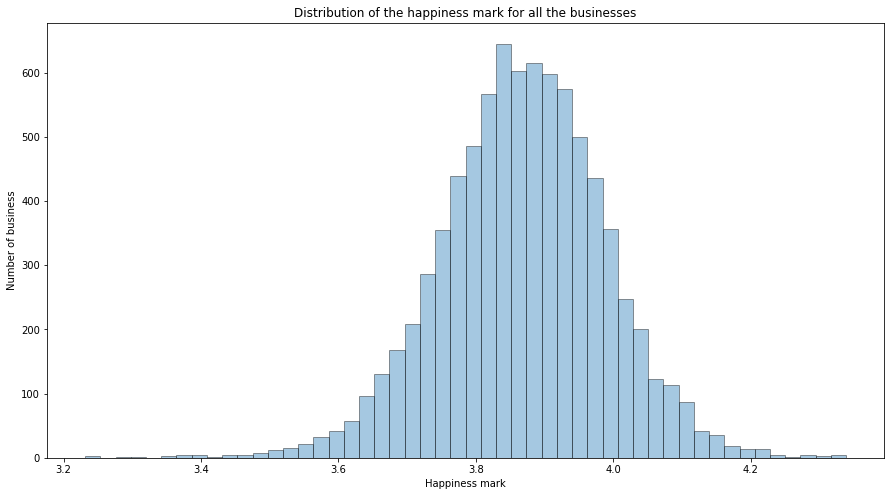

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# tuning matplotlib parameters
plt.rcParams["figure.figsize"] = [15, 8];
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'b'

# creating a dataframe with columns: business_id, grade
df = pd.DataFrame.from_dict(dic_rate, orient='index')

# plot
sns.distplot(df, kde=False);
plt.title("Distribution of the happiness mark for all the businesses");
plt.xlabel("Happiness mark");
plt.ylabel("Number of business");
plt.savefig("Website/happiness_distribution.png")

<li style="color:#001976; font-weight:bold; font-size:1.2em;" id="diff_marks">Observing the difference between our happiness mark and the number of stars</li>

In [268]:
list_business = list(dic_rate.keys())

# only keeping the businesses that have a happiness mark
df_business_filtered = df_business[df_business.business_id.isin(list_business)]

# creating a dic with key business_id and value a list containing the happiness and stars marks if existing
dic_marks = {elt: [dic_rate[elt], df_business_filtered[df_business_filtered.business_id == elt].stars.values[0]] for elt in list_business if len(df_business_filtered[df_business_filtered.business_id == elt].stars.values)>0}

In [269]:
# creating list containing the two different marks
rate, stars = [elt[0] for elt in dic_bis.values()], [elt[1] for elt in dic_bis.values()]

# computing a dilatation factor for both list in order to enlarge the scope of values
# and to set the lowest value to 0 and the highest one to 5
dilatation_factor_rate, dilatation_factor_stars = 5 / (max(rate) - min(rate)), 5 / (max(stars) - min(stars))

# computing the new values
rate = [dilatation_factor_rate * (elt - min(rate)) for elt in rate]
stars = [dilatation_factor_stars * (elt - min(stars)) for elt in stars]

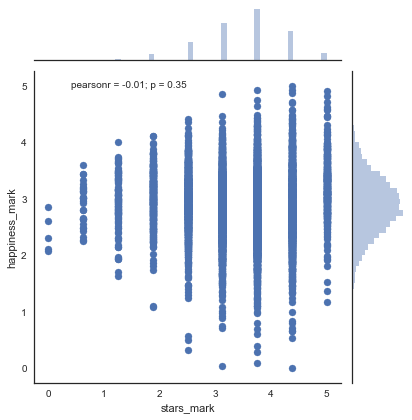

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

a = pd.DataFrame({"happiness_mark":rate, "stars_mark":stars})
sns.jointplot(x="stars_mark", y="happiness_mark", data=a, kind="scatter");

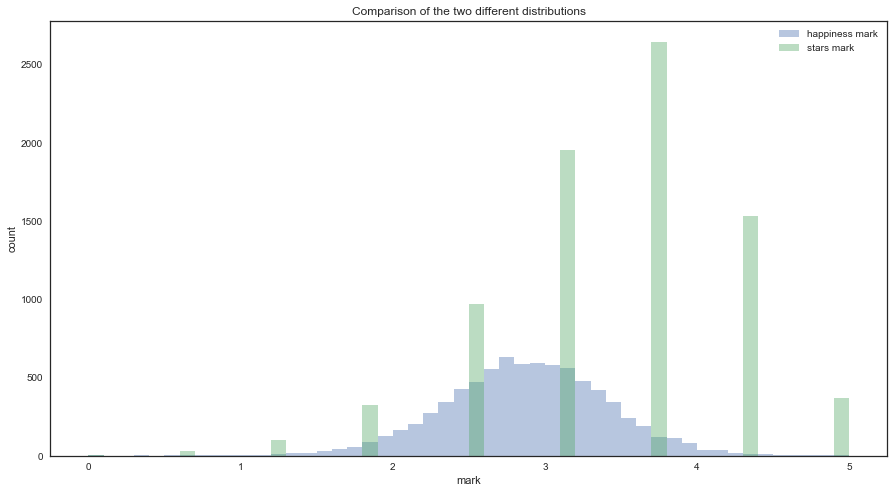

In [271]:
sns.distplot(rate, kde=False, label="happiness mark");
sns.distplot(stars, kde=False, label="stars mark");
plt.title("Comparison of the two different distributions")
plt.xlabel("mark");
plt.ylabel("count");
plt.legend();

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:2em; text-align: center;"> Comparison of the rate distribution within different categories</h2>

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Finding the most used categories.</li>

In [274]:
import operator

# function returning a dictionnary with key string and value the nb of occurence
def countingOccurencesListOfLists(list_of_lists):
    flattened = [val.lstrip() for sublist in list_of_lists for val in sublist] # flattening the list of lists
    dic = {key : 0 for key in flattened}
    for row in list_of_lists:
        for elt in row:
            dic[elt.lstrip()] += 1
            
    return dic

# sorting the tuples according to their nb of occurences
most_used_categories = countingOccurencesListOfLists(list(df_business.categories.values))
most_used_categories = sorted(most_used_categories.items(), key=lambda item: (item[1], item[0]), reverse=True)

for elt in most_used_categories[:10]:
    print("Category:", elt[0], "- number of occurences:", elt[1])

Category: Restaurants - number of occurences: 5518
Category: Food - number of occurences: 1724
Category: Nightlife - number of occurences: 1486
Category: Bars - number of occurences: 1399
Category: American (Traditional) - number of occurences: 907
Category: American (New) - number of occurences: 724
Category: Breakfast & Brunch - number of occurences: 708
Category: Sandwiches - number of occurences: 650
Category: Pizza - number of occurences: 554
Category: Italian - number of occurences: 536


In [275]:
# function filtering a specific dataframe column by a list of values
def filterDfByListElement(filteringList, df, column):
    indexToDrop = []
    for i in range(len(df)):
        categories = df.loc[i][column]
        if len(set(categories) & set(filteringList)) == 0:
            indexToDrop.append(i)
            
    df = df.drop(indexToDrop)
    df = df.reset_index(drop=True)
    return df

<li style="color:#001976; font-weight:bold; font-size:1.2em;" id="diff_categories"> Ploting the different distribution for the 10 main categories</li>

In [260]:
categorie1, categorie2, categorie3, categorie4, categorie5, categorie6, categorie7, categorie8, categorie9, categorie10 = 'Restaurants', 'Food', "Nightlife", "Bars", "American (Traditional)", "American (New)", "Breakfast & Brunch", "Sandwiches", "Pizza", "Italian"  

df_filtered_business_1 = filterDfByListElement([categorie1], df_business, 'categories')
df_filtered_business_2 = filterDfByListElement([categorie2], df_business, 'categories')
df_filtered_business_3 = filterDfByListElement([categorie3], df_business, 'categories')
df_filtered_business_4 = filterDfByListElement([categorie4], df_business, 'categories')
df_filtered_business_5 = filterDfByListElement([categorie5], df_business, 'categories')
df_filtered_business_6 = filterDfByListElement([categorie6], df_business, 'categories')
df_filtered_business_7 = filterDfByListElement([categorie7], df_business, 'categories')
df_filtered_business_8 = filterDfByListElement([categorie8], df_business, 'categories')
df_filtered_business_9 = filterDfByListElement([categorie9], df_business, 'categories')
df_filtered_business_10 = filterDfByListElement([categorie10], df_business, 'categories')

list_filter_business_id_1 = list(df_filtered_business_1.business_id.values)
list_filter_business_id_2 = list(df_filtered_business_2.business_id.values)
list_filter_business_id_3 = list(df_filtered_business_3.business_id.values)
list_filter_business_id_4 = list(df_filtered_business_4.business_id.values)
list_filter_business_id_5 = list(df_filtered_business_5.business_id.values)
list_filter_business_id_6 = list(df_filtered_business_6.business_id.values)
list_filter_business_id_7 = list(df_filtered_business_7.business_id.values)
list_filter_business_id_8 = list(df_filtered_business_8.business_id.values)
list_filter_business_id_9 = list(df_filtered_business_9.business_id.values)
list_filter_business_id_10 = list(df_filtered_business_10.business_id.values)

dic_filtered_1 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_1}
dic_filtered_2 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_2}
dic_filtered_3 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_3}
dic_filtered_4 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_4}
dic_filtered_5 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_5}
dic_filtered_6 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_6}
dic_filtered_7 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_7}
dic_filtered_8 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_8}
dic_filtered_9 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_9}
dic_filtered_10 = {business_id: dic_rate[business_id] for business_id in list_filter_business_id_10}

# dilating the range of values to get values between 0 and 5
d_1, min_1 = 5 / (max(list(dic_filtered_1.values())) - min(list(dic_filtered_1.values()))), min(list(dic_filtered_1.values()))
d_2, min_2 = 5 / (max(list(dic_filtered_2.values())) - min(list(dic_filtered_2.values()))), min(list(dic_filtered_2.values()))
d_3, min_3 = 5 / (max(list(dic_filtered_3.values())) - min(list(dic_filtered_3.values()))), min(list(dic_filtered_3.values()))
d_4, min_4 = 5 / (max(list(dic_filtered_4.values())) - min(list(dic_filtered_4.values()))), min(list(dic_filtered_4.values()))
d_5, min_5 = 5 / (max(list(dic_filtered_5.values())) - min(list(dic_filtered_5.values()))), min(list(dic_filtered_5.values()))
d_6, min_6 = 5 / (max(list(dic_filtered_6.values())) - min(list(dic_filtered_6.values()))), min(list(dic_filtered_6.values()))
d_7, min_7 = 5 / (max(list(dic_filtered_7.values())) - min(list(dic_filtered_7.values()))), min(list(dic_filtered_7.values()))
d_8, min_8 = 5 / (max(list(dic_filtered_8.values())) - min(list(dic_filtered_8.values()))), min(list(dic_filtered_8.values()))
d_9, min_9 = 5 / (max(list(dic_filtered_9.values())) - min(list(dic_filtered_9.values()))), min(list(dic_filtered_9.values()))
d_10, min_10 = 5 / (max(list(dic_filtered_10.values())) - min(list(dic_filtered_10.values()))), min(list(dic_filtered_10.values()))

dic_filtered_1 = {key: (value - min_1)*d for key, value in dic_filtered_1.items()}
dic_filtered_2 = {key: (value - min_2)*d for key, value in dic_filtered_2.items()}
dic_filtered_3 = {key: (value - min_3)*d for key, value in dic_filtered_3.items()}
dic_filtered_4 = {key: (value - min_4)*d for key, value in dic_filtered_4.items()}
dic_filtered_5 = {key: (value - min_5)*d for key, value in dic_filtered_5.items()}
dic_filtered_6 = {key: (value - min_6)*d for key, value in dic_filtered_6.items()}
dic_filtered_7 = {key: (value - min_7)*d for key, value in dic_filtered_7.items()}
dic_filtered_8 = {key: (value - min_8)*d for key, value in dic_filtered_8.items()}
dic_filtered_9 = {key: (value - min_9)*d for key, value in dic_filtered_9.items()}
dic_filtered_10 = {key: (value - min_10)*d for key, value in dic_filtered_10.items()}

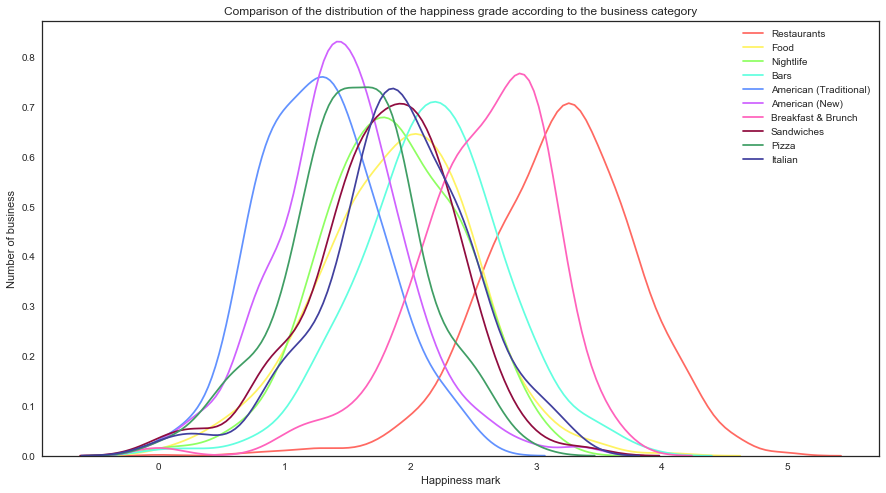

In [259]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

df1 = pd.DataFrame.from_dict(dic_filtered_1, orient='index')
df2 = pd.DataFrame.from_dict(dic_filtered_2, orient='index')
df3 = pd.DataFrame.from_dict(dic_filtered_3, orient='index')
df4 = pd.DataFrame.from_dict(dic_filtered_4, orient='index')
df5 = pd.DataFrame.from_dict(dic_filtered_5, orient='index')
df6 = pd.DataFrame.from_dict(dic_filtered_6, orient='index')
df7 = pd.DataFrame.from_dict(dic_filtered_7, orient='index')
df8 = pd.DataFrame.from_dict(dic_filtered_8, orient='index')
df9 = pd.DataFrame.from_dict(dic_filtered_9, orient='index')
df10 = pd.DataFrame.from_dict(dic_filtered_10, orient='index')

sns.distplot(df1, label=categorie1, hist=False, color="#FF6962");
sns.distplot(df2, label=categorie2, hist=False, color="#FFF362");
sns.distplot(df3, label=categorie3, hist=False, color="#8FFF62");
sns.distplot(df4, label=categorie4, hist=False, color="#62FFE0");
sns.distplot(df5, label=categorie5, hist=False, color="#6292FF");
sns.distplot(df6, label=categorie6, hist=False, color="#CF62FF");
sns.distplot(df7, label=categorie7, hist=False, color="#FF62BC");
sns.distplot(df8, label=categorie8, hist=False, color="#900C3F");
sns.distplot(df9, label=categorie9, hist=False, color="#409E65");
sns.distplot(df10, label=categorie10, hist=False, color="#41409E");

plt.title("Comparison of the distribution of the happiness grade according to the business category");
plt.xlabel("Happiness mark");
plt.ylabel("Number of business");
plt.legend();
plt.savefig("Website/happiness_comparison_categories.png")

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:2em; text-align: center;"> Wordclouds</h2>

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Defining functions in order to compute the: TF, IDF, TFIDF of a text. </li>

In [17]:
import nltk
from nltk.corpus import stopwords
import re

def computeTF(text):
    fdist = nltk.FreqDist(text)
    tf = dict()
    for (i,j) in fdist.most_common():
        tf[i] = float(j) / len(text)
    return tf

def computeIDF(text):
    import math
    idf = dict()
    n = len(text)
    for word in text:
        if word not in idf:
            idf[word] = 1
        else:
            idf[word] += 1
    for word,val in idf.items():
        idf[word] = math.log10(n / float(val))
    return idf

def computeTFIDF(text):
    tf = computeTF(text)
    idf = computeIDF(text)
    tfidf = dict()
    for word,value in tf.items():
        tfidf[word] = value*idf[word]
    return tfidf

<li style="color:#001976; font-weight:bold; font-size:1.2em;">Preprocessing the text in order to remove unneeded words and punctuations. We are here processing with the comments of one category, but you can observe <a href="http://www.student.dtu.dk/~s182291/Website/sentiments.html#wordclouds" target="_blank">here</a> our different results.</li>

In [20]:
with open("../yelp_dataset/comments_by_category/comments_Restaurants.json", "r") as f:
    text = f.read()
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # removing stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # removing punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # removing digits

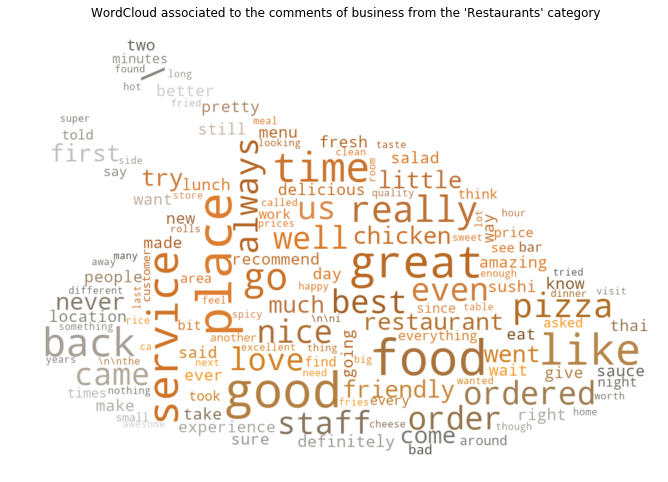

In [25]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests

# function creating a Wordcloud associated to a tfidf statistic
def generate_wordcloud(tfidf):
#     giving a background image to plot the words
    mask = np.array(Image.open(requests.get("https://media.istockphoto.com/vectors/vector-cartoon-hand-drawn-cooked-turkey-bird-vector-id693252012", stream=True).raw))
    
    wordcloud = WordCloud(background_color="white", max_font_size=80,max_words=140, mask=mask).generate_from_frequencies(frequencies=tfidf)

#    creating coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    
#     ploting
    plt.axis("off")
    plt.title("WordCloud associated to the comments of business from the 'Restaurants' category")
    plt.savefig("Restaurant_wordcloud.png")

generate_wordcloud(computeTFIDF(words))

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:2em; text-align: center;"> Statistics on elite users</h2>

In [114]:
# function to split the 'friends' attribute into a list
def split_friends(row):
    row['friends'] = row['friends'].split(",")
    return row

In [96]:
import json
import pandas as pd
import os

list_path_dir = ["../yelp_dataset/elite_users_2015.json/", "../yelp_dataset/elite_users_2016.json/", "../yelp_dataset/elite_users_2017.json/"]
list_list_dir = [os.listdir(list_path_dir[0]), os.listdir(list_path_dir[1]), os.listdir(list_path_dir[2])]


elite_users_15, elite_users_16, elite_users_17 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for file in list_list_dir[0]:
    df = pd.read_json(list_path_dir[0] + file, lines=True)
    elite_users_15 = pd.concat([elite_users_15, df])
    
for file in list_list_dir[1]:
    df = pd.read_json(list_path_dir[1] + file, lines=True)
    elite_users_16 = pd.concat([elite_users_16, df])
    
for file in list_list_dir[2]:
    df = pd.read_json(list_path_dir[2] + file, lines=True)
    elite_users_17 = pd.concat([elite_users_17, df])
    
    
# reindexing the dataframes by user_id
elite_users_15, elite_users_16, elite_users_17 = elite_users_15.set_index("user_id"), elite_users_16.set_index("user_id"), elite_users_17.set_index("user_id")

# changing type of friends column to list
elite_users_15.friends, elite_users_16.friends, elite_users_17.friends = elite_users_15['friends'].map(lambda a: a.split(",")), elite_users_16['friends'].map(lambda a: a.split(",")), elite_users_17['friends'].map(lambda a: a.split(","))

# writing dataframes as dictionnaries
dic_15, dic_16, dic_17 = elite_users_15.to_dict('index'), elite_users_16.to_dict('index'), elite_users_17.to_dict('index')

In [97]:
# list of dictionnaries with user a key and his number of friends as value
friend_count = [{user: len(dic_15[user]['friends']) for user in dic_15.keys()},
                {user: len(dic_16[user]['friends']) for user in dic_16.keys()},
                {user: len(dic_17[user]['friends']) for user in dic_17.keys()}]

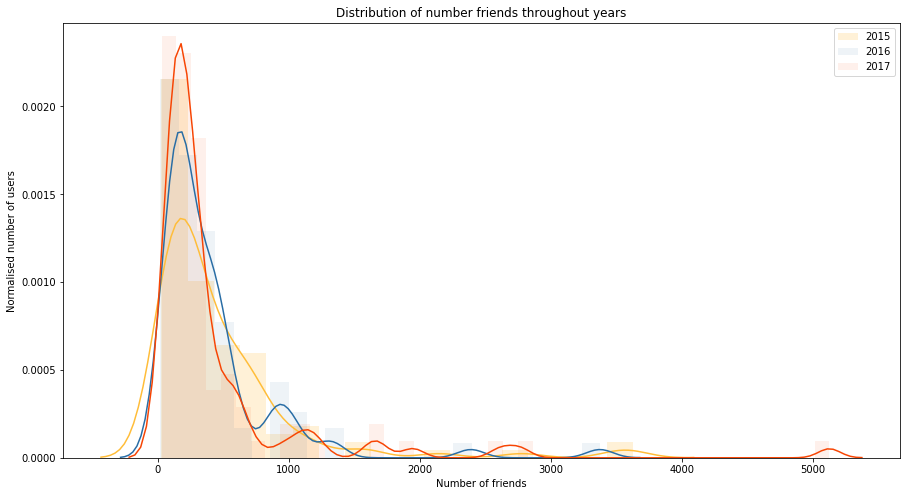

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['patch.force_edgecolor'] = False
rcParams['patch.facecolor'] = 'b'

df_15 = pd.DataFrame.from_dict(friend_count[0], orient='index')
df_16 = pd.DataFrame.from_dict(friend_count[1], orient='index')
df_17 = pd.DataFrame.from_dict(friend_count[2], orient='index')

sns.distplot(df_15, label='2015', hist_kws=dict(alpha=.08), color="#FFBD39");
sns.distplot(df_16, label='2016', hist_kws=dict(alpha=.08), color="#296DA5");
sns.distplot(df_17, label='2017', hist_kws=dict(alpha=.08), color="#f74504");

plt.title("Distribution of number friends throughout years");
plt.xlabel("Number of friends");
plt.ylabel("Normalised number of users");
plt.legend();
plt.savefig("Website/user_friends_distribution.png")

In [104]:
# list of dictionnaries with user a key and his number of fans as value
fan_count = [{user: dic_15[user]['fans'] for user in dic_15.keys()},
             {user: dic_16[user]['fans'] for user in dic_16.keys()},
             {user: dic_17[user]['fans'] for user in dic_17.keys()}]

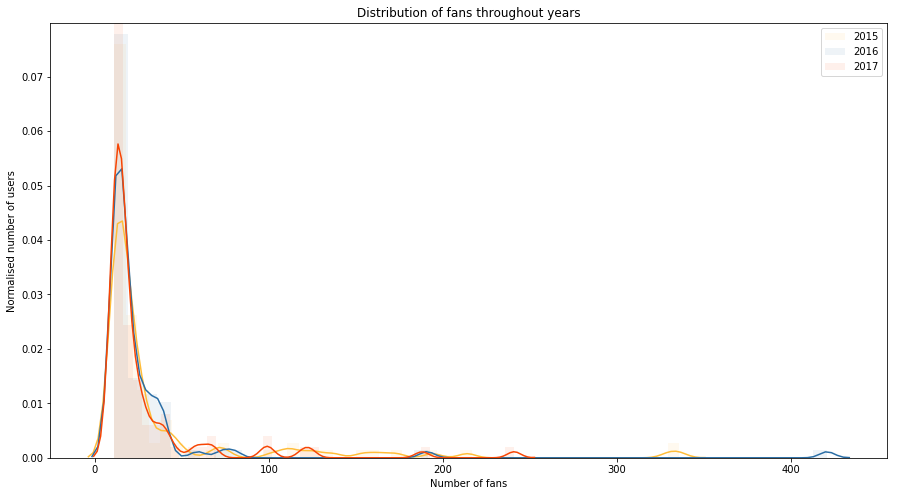

In [105]:
df_15 = pd.DataFrame.from_dict(fan_count[0], orient='index')
df_16 = pd.DataFrame.from_dict(fan_count[1], orient='index')
df_17 = pd.DataFrame.from_dict(fan_count[2], orient='index')

sns.distplot(df_15, label='2015', hist_kws=dict(alpha=.08), color="#FFBD39");
sns.distplot(df_16, label='2016', hist_kws=dict(alpha=.08), color="#296DA5");
sns.distplot(df_17, label='2017', hist_kws=dict(alpha=.08), color="#f74504");

plt.title("Distribution of fans throughout years");
plt.xlabel("Number of fans");
plt.ylabel("Normalised number of users");
plt.legend();
plt.savefig("Website/user_fan_distribution.png")

In [106]:
# list of dictionnaries with user a key and his number of reviews as value
review_count = [{user: dic_15[user]['review_count'] for user in dic_15.keys()},
                {user: dic_16[user]['review_count'] for user in dic_16.keys()},
                {user: dic_17[user]['review_count'] for user in dic_17.keys()}]

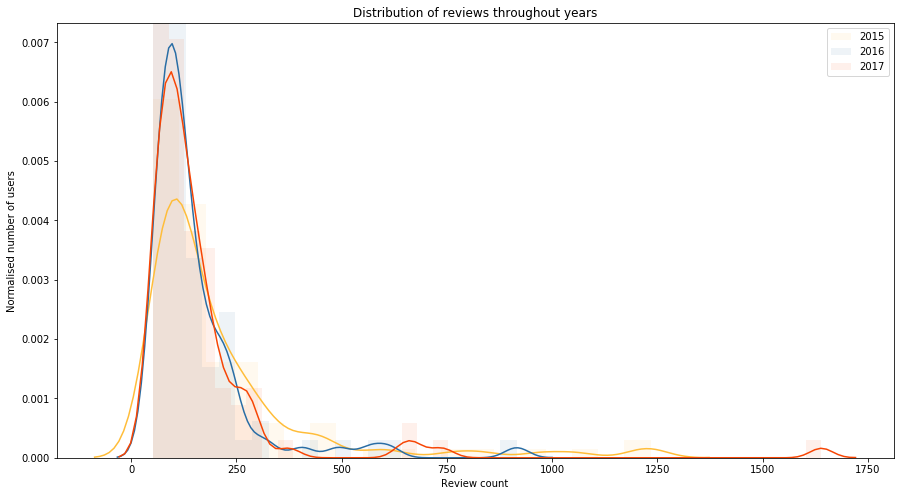

In [107]:
df_15 = pd.DataFrame.from_dict(review_count[0], orient='index')
df_16 = pd.DataFrame.from_dict(review_count[1], orient='index')
df_17 = pd.DataFrame.from_dict(review_count[2], orient='index')

sns.distplot(df_15, label='2015', hist_kws=dict(alpha=.08), color="#FFBD39")
sns.distplot(df_16, label='2016', hist_kws=dict(alpha=.08), color="#296DA5")
sns.distplot(df_17, label='2017', hist_kws=dict(alpha=.08), color="#f74504")

plt.title("Distribution of reviews throughout years");
plt.xlabel("Review count");
plt.ylabel("Normalised number of users");
plt.legend();
plt.savefig("Website/user_review_distribution.png")

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:2em; text-align: center;"> Networks</h2>

<h2 style="color:#001976; font-weight:bold; text-decoration:underline;"> 1. Network of elite users</h2>
<p style="color:#001976; font-weight:bold; font-size:1.2em;"> We are here only ploting the results for the elite users of the year 2015, but you can find <a href="http://www.student.dtu.dk/~s182291/Website/network.html#users_network" target="_blank">here</a> the results for the different years.</p>

In [108]:
import networkx as nx

user_nw_undir = nx.Graph()

user_nw_undir.add_nodes_from(list(dic_15.keys()), node_color='blue')

for key in dic:
    for elt in dic_15[key]['friends']:
        user_nw_undir.add_node(elt, node_color='red')
        user_nw_undir.add_edge(key, elt)

In [170]:
import fa2
import matplotlib.pyplot as plt


forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(user_nw_undir,
                                                    pos=None,
                                                    iterations=2000)




  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 1/2000 [00:00<31:18,  1.06it/s]


  0%|          | 2/2000 [00:02<33:35,  1.01s/it]


  0%|          | 3/2000 [00:03<39:04,  1.17s/it]


  0%|          | 4/2000 [00:04<39:38,  1.19s/it]


  0%|          | 5/2000 [00:06<39:46,  1.20s/it]


  0%|          | 6/2000 [00:06<36:06,  1.09s/it]


  0%|          | 7/2000 [00:08<37:06,  1.12s/it]


  0%|          | 8/2000 [00:08<32:30,  1.02it/s]


  0%|          | 9/2000 [00:09<34:12,  1.03s/it]


  0%|          | 10/2000 [00:11<36:56,  1.11s/it]


  1%|          | 11/2000 [00:12<37:32,  1.13s/it]


  1%|          | 12/2000 [00:13<35:44,  1.08s/it]


  1%|          | 13/2000 [00:14<36:14,  1.09s/it]


  1%|          | 14/2000 [00:15<35:30,  1.07s/it]


  1%|          | 15/2000 [00:16<30:41,  1.08it/s]


  1%|          | 16/2000 [00:17<31:21,  1.05it/s]


  1%|          | 17/2000 [00:17<27:30,  1.20it/s]


  1%|          | 18/2000 [00:18<28:46,  1.15it/s]


  1%|          | 19/2000 [0

  7%|▋         | 134/2000 [01:46<19:32,  1.59it/s]


  7%|▋         | 135/2000 [01:46<21:07,  1.47it/s]


  7%|▋         | 136/2000 [01:47<22:16,  1.40it/s]


  7%|▋         | 137/2000 [01:48<23:12,  1.34it/s]


  7%|▋         | 138/2000 [01:48<20:00,  1.55it/s]


  7%|▋         | 139/2000 [01:49<21:28,  1.44it/s]


  7%|▋         | 140/2000 [01:50<22:39,  1.37it/s]


  7%|▋         | 141/2000 [01:50<19:34,  1.58it/s]


  7%|▋         | 142/2000 [01:51<21:11,  1.46it/s]


  7%|▋         | 143/2000 [01:52<18:37,  1.66it/s]


  7%|▋         | 144/2000 [01:52<20:19,  1.52it/s]


  7%|▋         | 145/2000 [01:53<21:44,  1.42it/s]


  7%|▋         | 146/2000 [01:54<22:43,  1.36it/s]


  7%|▋         | 147/2000 [01:55<19:37,  1.57it/s]


  7%|▋         | 148/2000 [01:55<21:05,  1.46it/s]


  7%|▋         | 149/2000 [01:56<18:25,  1.67it/s]


  8%|▊         | 150/2000 [01:56<20:11,  1.53it/s]


  8%|▊         | 151/2000 [01:57<21:23,  1.44it/s]


  8%|▊         | 152/2000 [01:58<22:25,  1.37i

 20%|█▉        | 398/2000 [04:39<16:11,  1.65it/s]


 20%|█▉        | 399/2000 [04:40<17:16,  1.55it/s]


 20%|██        | 400/2000 [04:41<15:02,  1.77it/s]


 20%|██        | 401/2000 [04:41<16:16,  1.64it/s]


 20%|██        | 402/2000 [04:42<17:19,  1.54it/s]


 20%|██        | 403/2000 [04:42<15:01,  1.77it/s]


 20%|██        | 404/2000 [04:43<16:20,  1.63it/s]


 20%|██        | 405/2000 [04:44<17:17,  1.54it/s]


 20%|██        | 406/2000 [04:45<18:07,  1.47it/s]


 20%|██        | 407/2000 [04:45<15:31,  1.71it/s]


 20%|██        | 408/2000 [04:46<16:46,  1.58it/s]


 20%|██        | 409/2000 [04:46<14:35,  1.82it/s]


 20%|██        | 410/2000 [04:47<16:01,  1.65it/s]


 21%|██        | 411/2000 [04:48<17:03,  1.55it/s]


 21%|██        | 412/2000 [04:48<14:51,  1.78it/s]


 21%|██        | 413/2000 [04:49<16:12,  1.63it/s]


 21%|██        | 414/2000 [04:49<17:09,  1.54it/s]


 21%|██        | 415/2000 [04:50<17:53,  1.48it/s]


 21%|██        | 416/2000 [04:50<15:27,  1.71i

 33%|███▎      | 662/2000 [07:29<14:29,  1.54it/s]


 33%|███▎      | 663/2000 [07:30<15:06,  1.47it/s]


 33%|███▎      | 664/2000 [07:31<13:01,  1.71it/s]


 33%|███▎      | 665/2000 [07:31<13:58,  1.59it/s]


 33%|███▎      | 666/2000 [07:32<12:15,  1.81it/s]


 33%|███▎      | 667/2000 [07:32<13:27,  1.65it/s]


 33%|███▎      | 668/2000 [07:33<14:15,  1.56it/s]


 33%|███▎      | 669/2000 [07:33<12:28,  1.78it/s]


 34%|███▎      | 670/2000 [07:34<13:34,  1.63it/s]


 34%|███▎      | 671/2000 [07:35<14:21,  1.54it/s]


 34%|███▎      | 672/2000 [07:35<12:24,  1.78it/s]


 34%|███▎      | 673/2000 [07:36<13:28,  1.64it/s]


 34%|███▎      | 674/2000 [07:37<14:16,  1.55it/s]


 34%|███▍      | 675/2000 [07:37<12:25,  1.78it/s]


 34%|███▍      | 676/2000 [07:38<13:26,  1.64it/s]


 34%|███▍      | 677/2000 [07:39<14:12,  1.55it/s]


 34%|███▍      | 678/2000 [07:39<12:19,  1.79it/s]


 34%|███▍      | 679/2000 [07:40<13:25,  1.64it/s]


 34%|███▍      | 680/2000 [07:40<14:12,  1.55i

 46%|████▋     | 926/2000 [10:37<11:15,  1.59it/s]


 46%|████▋     | 927/2000 [10:38<12:42,  1.41it/s]


 46%|████▋     | 928/2000 [10:39<13:06,  1.36it/s]


 46%|████▋     | 929/2000 [10:39<13:13,  1.35it/s]


 46%|████▋     | 930/2000 [10:40<11:18,  1.58it/s]


 47%|████▋     | 931/2000 [10:41<12:07,  1.47it/s]


 47%|████▋     | 932/2000 [10:41<12:35,  1.41it/s]


 47%|████▋     | 933/2000 [10:42<10:50,  1.64it/s]


 47%|████▋     | 934/2000 [10:43<12:06,  1.47it/s]


 47%|████▋     | 935/2000 [10:43<10:36,  1.67it/s]


 47%|████▋     | 936/2000 [10:44<11:28,  1.54it/s]


 47%|████▋     | 937/2000 [10:44<12:07,  1.46it/s]


 47%|████▋     | 938/2000 [10:45<10:29,  1.69it/s]


 47%|████▋     | 939/2000 [10:46<11:21,  1.56it/s]


 47%|████▋     | 940/2000 [10:46<12:01,  1.47it/s]


 47%|████▋     | 941/2000 [10:47<10:25,  1.69it/s]


 47%|████▋     | 942/2000 [10:48<11:33,  1.53it/s]


 47%|████▋     | 943/2000 [10:48<12:30,  1.41it/s]


 47%|████▋     | 944/2000 [10:49<10:46,  1.63i

 59%|█████▉    | 1187/2000 [13:28<08:55,  1.52it/s]


 59%|█████▉    | 1188/2000 [13:28<08:24,  1.61it/s]


 59%|█████▉    | 1189/2000 [13:29<09:06,  1.48it/s]


 60%|█████▉    | 1190/2000 [13:30<09:27,  1.43it/s]


 60%|█████▉    | 1191/2000 [13:30<08:06,  1.66it/s]


 60%|█████▉    | 1192/2000 [13:31<08:40,  1.55it/s]


 60%|█████▉    | 1193/2000 [13:32<09:21,  1.44it/s]


 60%|█████▉    | 1194/2000 [13:32<08:10,  1.64it/s]


 60%|█████▉    | 1195/2000 [13:33<08:44,  1.54it/s]


 60%|█████▉    | 1196/2000 [13:34<09:06,  1.47it/s]


 60%|█████▉    | 1197/2000 [13:35<09:48,  1.37it/s]


 60%|█████▉    | 1198/2000 [13:35<08:23,  1.59it/s]


 60%|█████▉    | 1199/2000 [13:36<08:55,  1.50it/s]


 60%|██████    | 1200/2000 [13:36<07:41,  1.73it/s]


 60%|██████    | 1201/2000 [13:37<08:11,  1.63it/s]


 60%|██████    | 1202/2000 [13:38<08:48,  1.51it/s]


 60%|██████    | 1203/2000 [13:38<07:42,  1.72it/s]


 60%|██████    | 1204/2000 [13:39<08:16,  1.60it/s]


 60%|██████    | 1205/2000 [

 72%|███████▏  | 1447/2000 [16:19<06:42,  1.37it/s]


 72%|███████▏  | 1448/2000 [16:20<05:40,  1.62it/s]


 72%|███████▏  | 1449/2000 [16:21<06:46,  1.36it/s]


 72%|███████▎  | 1450/2000 [16:22<07:40,  1.19it/s]


 73%|███████▎  | 1451/2000 [16:22<06:42,  1.36it/s]


 73%|███████▎  | 1452/2000 [16:23<07:00,  1.30it/s]


 73%|███████▎  | 1453/2000 [16:23<05:53,  1.55it/s]


 73%|███████▎  | 1454/2000 [16:24<06:08,  1.48it/s]


 73%|███████▎  | 1455/2000 [16:25<06:19,  1.44it/s]


 73%|███████▎  | 1456/2000 [16:25<05:33,  1.63it/s]


 73%|███████▎  | 1457/2000 [16:26<05:59,  1.51it/s]


 73%|███████▎  | 1458/2000 [16:27<06:15,  1.44it/s]


 73%|███████▎  | 1459/2000 [16:27<05:19,  1.70it/s]


 73%|███████▎  | 1460/2000 [16:28<05:51,  1.54it/s]


 73%|███████▎  | 1461/2000 [16:29<06:10,  1.45it/s]


 73%|███████▎  | 1462/2000 [16:29<05:26,  1.65it/s]


 73%|███████▎  | 1463/2000 [16:30<05:54,  1.51it/s]


 73%|███████▎  | 1464/2000 [16:31<06:08,  1.46it/s]


 73%|███████▎  | 1465/2000 [

 85%|████████▌ | 1707/2000 [19:14<03:13,  1.51it/s]


 85%|████████▌ | 1708/2000 [19:14<03:23,  1.44it/s]


 85%|████████▌ | 1709/2000 [19:15<03:28,  1.39it/s]


 86%|████████▌ | 1710/2000 [19:16<02:57,  1.63it/s]


 86%|████████▌ | 1711/2000 [19:16<03:08,  1.53it/s]


 86%|████████▌ | 1712/2000 [19:17<03:16,  1.46it/s]


 86%|████████▌ | 1713/2000 [19:17<02:51,  1.67it/s]


 86%|████████▌ | 1714/2000 [19:18<03:09,  1.51it/s]


 86%|████████▌ | 1715/2000 [19:19<03:17,  1.44it/s]


 86%|████████▌ | 1716/2000 [19:19<02:49,  1.68it/s]


 86%|████████▌ | 1717/2000 [19:20<03:01,  1.56it/s]


 86%|████████▌ | 1718/2000 [19:21<02:38,  1.78it/s]


 86%|████████▌ | 1719/2000 [19:21<02:53,  1.62it/s]


 86%|████████▌ | 1720/2000 [19:22<03:06,  1.50it/s]


 86%|████████▌ | 1721/2000 [19:22<02:40,  1.74it/s]


 86%|████████▌ | 1722/2000 [19:23<03:06,  1.49it/s]


 86%|████████▌ | 1723/2000 [19:24<03:18,  1.40it/s]


 86%|████████▌ | 1724/2000 [19:25<02:52,  1.60it/s]


 86%|████████▋ | 1725/2000 [

 98%|█████████▊| 1967/2000 [22:14<00:26,  1.24it/s]


 98%|█████████▊| 1968/2000 [22:15<00:27,  1.16it/s]


 98%|█████████▊| 1969/2000 [22:15<00:22,  1.37it/s]


 98%|█████████▊| 1970/2000 [22:16<00:23,  1.29it/s]


 99%|█████████▊| 1971/2000 [22:16<00:20,  1.43it/s]


 99%|█████████▊| 1972/2000 [22:17<00:20,  1.35it/s]


 99%|█████████▊| 1973/2000 [22:18<00:21,  1.24it/s]


 99%|█████████▊| 1974/2000 [22:19<00:18,  1.42it/s]


 99%|█████████▉| 1975/2000 [22:20<00:19,  1.31it/s]


 99%|█████████▉| 1976/2000 [22:21<00:20,  1.19it/s]


 99%|█████████▉| 1977/2000 [22:21<00:16,  1.36it/s]


 99%|█████████▉| 1978/2000 [22:22<00:17,  1.27it/s]


 99%|█████████▉| 1979/2000 [22:23<00:17,  1.20it/s]


 99%|█████████▉| 1980/2000 [22:23<00:14,  1.41it/s]


 99%|█████████▉| 1981/2000 [22:24<00:14,  1.27it/s]


 99%|█████████▉| 1982/2000 [22:25<00:15,  1.20it/s]


 99%|█████████▉| 1983/2000 [22:26<00:12,  1.38it/s]


 99%|█████████▉| 1984/2000 [22:27<00:12,  1.25it/s]


 99%|█████████▉| 1985/2000 [

BarnesHut Approximation  took  685.05  seconds
Repulsion forces  took  619.98  seconds
Gravitational forces  took  1.88  seconds
Attraction forces  took  3.53  seconds
AdjustSpeedAndApplyForces step  took  21.34  seconds


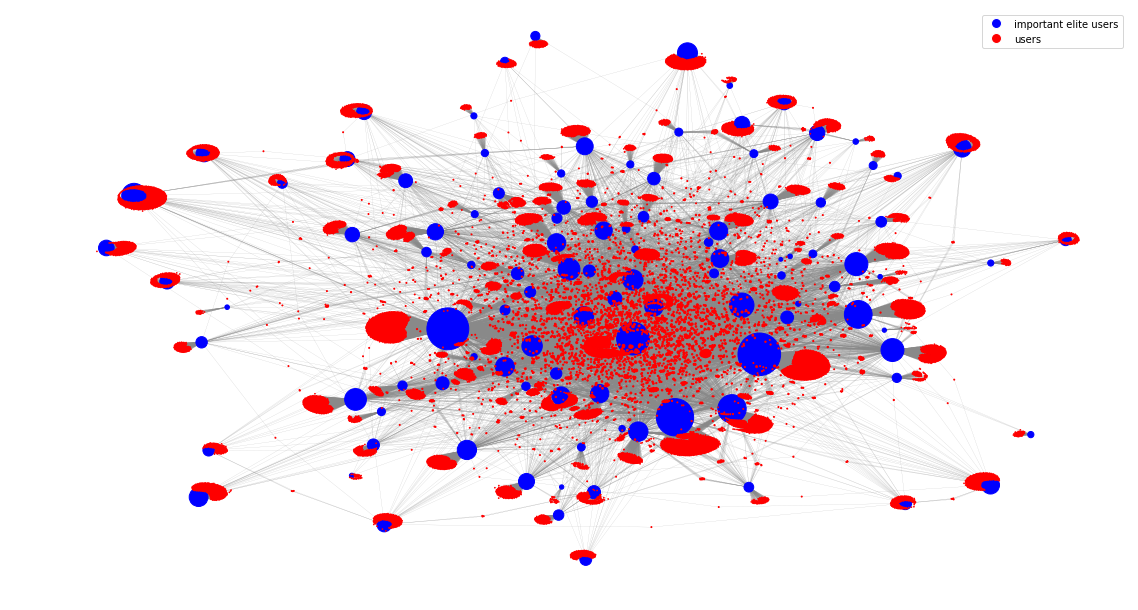

In [171]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='important elite users',
                          markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='users',
                          markerfacecolor='r', markersize=10)]

degrees = [degree[1]*0.5 for degree in nx.degree(user_nw_undir)]

node_color = list(nx.get_node_attributes(user_nw_undir,'node_color').values())

plt.rcParams["figure.figsize"] = [15, 8]
    
nx.draw(user_nw_undir,
        positions,
        cmap=plt.get_cmap('jet'),
        edge_color="#898989",
        node_size= degrees,
        node_color = node_color,
        overlap = False,
        width = .1,
        with_labels=False)

plt.savefig("elite_users_network_2015.png")
plt.legend(handles=legend_elements)
plt.show()

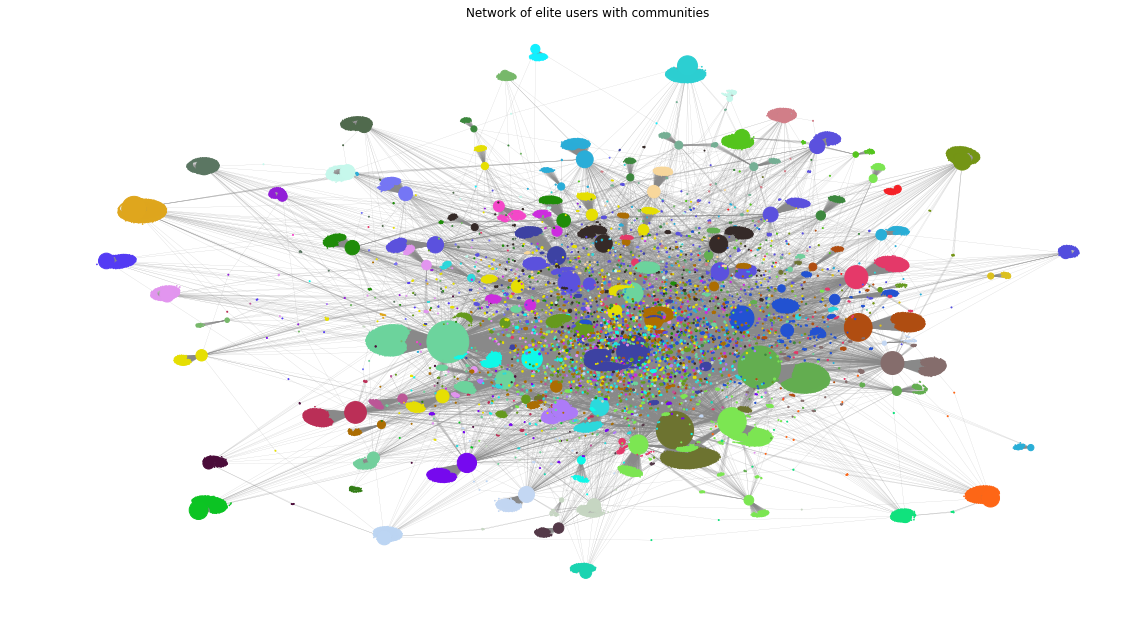

In [172]:
import community
import numpy as np

partition = community.best_partition(user_nw_undir)

node_color_indices = [node[1] for node in partition.items()]
partColors = {i: list(np.random.random(size=3)) for i in set(node_color_indices)}
node_colors = [partColors[index] for index in node_color_indices]

nx.draw(user_nw_undir, positions, node_color=node_colors,edge_color="#898989", node_size=degrees, width = 0.1, with_labels=False)
plt.title("Network of elite users with communities");
plt.savefig("network_elite_users_2015_com.png")

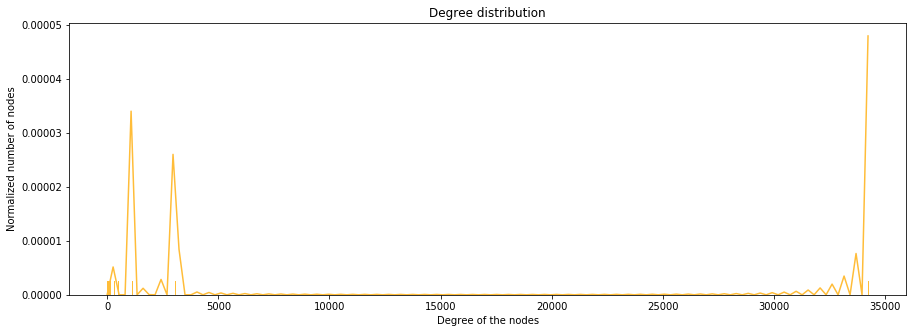

In [123]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [15, 5];
deg = [degree[1] for degree in nx.degree(user_nw_undir)]  
df_deg = pd.DataFrame(deg, columns=["degree"])

sns.distplot(df_deg.degree.value_counts(), hist=False,rug=True, color="#FFBD39");

plt.title("Degree distribution");
plt.ylabel("Normalized number of nodes");
plt.xlabel("Degree of the nodes");

<h2 style="color:#001976; font-weight:bold;  text-decoration:underline;"> 2. Network of businesses</h2><br>

<li style="color:#001976; font-weight:bold; font-size:1.2em;">We are here taking into account the comments of elite users of the year 2016 but you can find <a href="http://www.student.dtu.dk/~s182291/Website/network.html#business_network" target="_blank">here</a> the result for different years. </li>

In [41]:
import os
import pandas as pd

df_users_business = pd.DataFrame()
# loading json file with key users and values business they have written a comment about
folder = os.listdir("../yelp_dataset/elite_2016_and_business.json")

for file in folder:
    df = pd.read_json("../yelp_dataset/elite_2016_and_business.json/" + file, lines=True)
    df_users_business = pd.concat([df_users_business, df])

In [56]:
# filtering the businesses that have more than 100 elite visitors 
df_users_business = df_users_business.groupby("business_id").filter(lambda x: len(x) > 100)

In [57]:
# transform the group by into a dic where key is id and the value is a list of business_id
# in order to be able to draw edges between business linked by a common user
dic = df_users_business.groupby('user_id')['business_id'].apply(lambda x: x.tolist()).to_dict()

In [58]:
import networkx as nx
import itertools as it

G = nx.Graph()

for key in dic.keys():
    if len(dic[key]) > 1 and len(dic[key]) < 3:
        edges_to_draw = list(it.combinations(dic[key], 2)) #getting all 2-uples combination of the businesses
        G.add_edges_from(edges_to_draw)

In [62]:
import fa2
import matplotlib.pyplot as plt

forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(G,
                                                    pos=None,
                                                    iterations=4000)


100%|██████████| 4000/4000 [00:17<00:00, 226.38it/s]

BarnesHut Approximation  took  5.96  seconds
Repulsion forces  took  10.15  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.18  seconds
AdjustSpeedAndApplyForces step  took  0.60  seconds


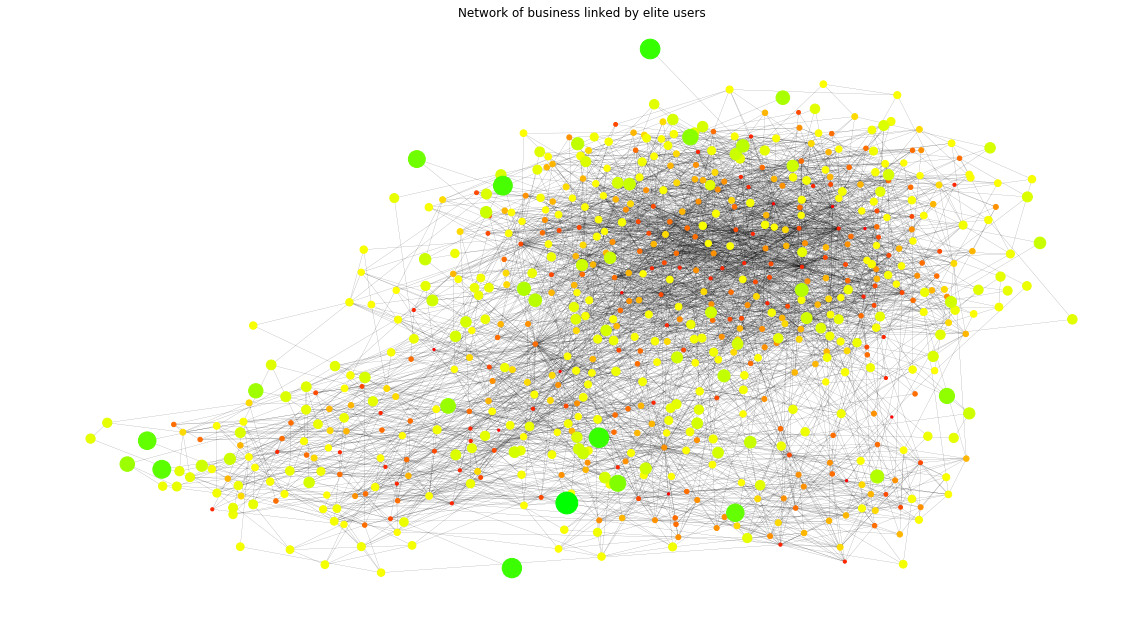

In [65]:
import statistics
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 8];

node_size = []
for elt in list(G.degree()):
    node_size.append(elt[1]*5)
    
node_size.sort()

# here we compute the color of each node regarding their degree
max_size = node_size[-1]
med_size = statistics.median(node_size)
min_size = node_size[0]

def aggregateColors(size):
    if size <= med_size:
        x = int(255*(size - min_size)/(med_size - min_size))
        return (1,x/255,0)
    else:
        x = int(255*(size - med_size)/(max_size - med_size))
        return ((255 - x)/255,1,0)

colors = [aggregateColors(size) for size in node_size]

nx.draw(G, positions, node_size=node_size, node_color=colors, width=.1)
plt.title("Network of business linked by elite users");
plt.savefig("network_business.png")

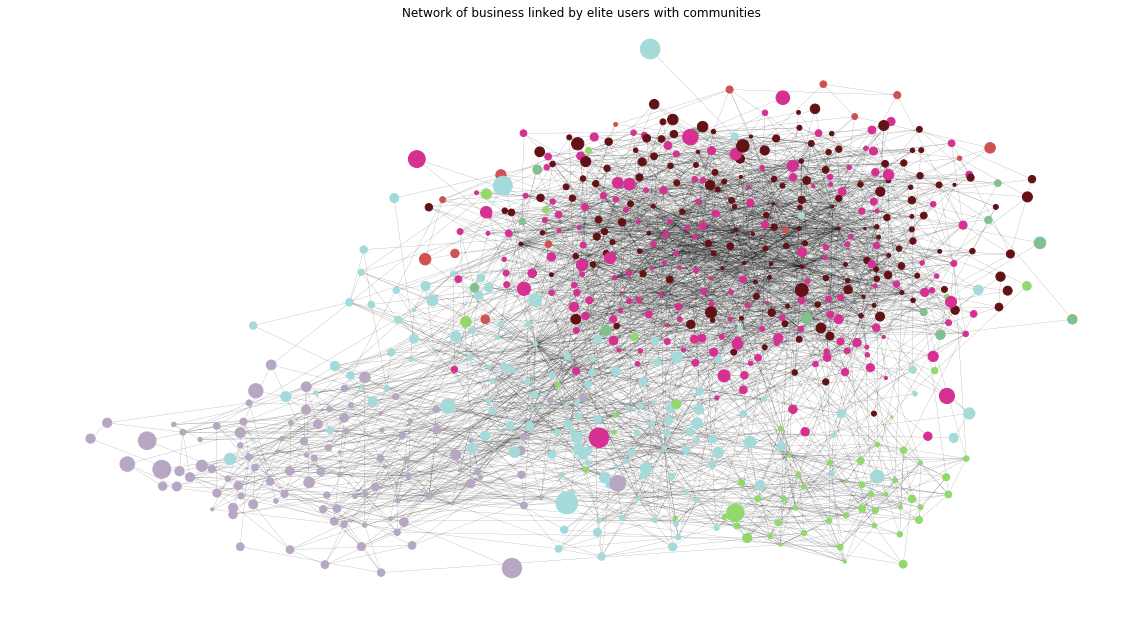

In [86]:
import community
import numpy as np

partition = community.best_partition(G)
node_color_indices = [node[1] for node in partition.items()]
partColors = {i: list(np.random.random(size=3)) for i in set(node_color_indices)}
node_colors = [partColors[index] for index in node_color_indices]

nx.draw(G, positions, node_color=node_colors, node_size=node_size, width=.1)
plt.title("Network of business linked by elite users with communities");
plt.savefig("network_business_communities.png")

<hr>

<h2 style="color:#001976; font-weight:bold; font-size:2em; text-align: center;"> Showing positions and rating on a map </h2>

In [173]:
# changing columns type to float
df_business["latitude"] = pd.to_numeric(df_business["latitude"]) 
df_business["longitude"] = pd.to_numeric(df_business["longitude"])

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Getting only the locations of the businesses which sentimental mark exist.</li>

In [174]:
# creating a d containing the localisations of all the analyzed business
locations = {}
for business in list(dic_rate.keys()):
    try:
        locations[business] =((df_business[df_business['business_id'] == business].latitude.values[0], df_business[df_business['business_id'] == business].longitude.values[0]))
    except IndexError:
        pass

<li style="color:#001976; font-weight:bold; font-size:1.2em;"> Giving a color to nodes according to their mark</li>

In [175]:
import statistics

# here we compute the color of each node (business) regarding their final mark
max_rate = max(dic_rate.values())
med_rate = statistics.median(dic_rate.values())
min_rate = min(dic_rate.values())

# function returning a color for a given mark
def aggregateColors(rate):
    if rate <= med_rate:
        x = int(255*(rate - min_rate)/(med_rate - min_rate))
        return (255, x, 0, 0.8)
    else:
        x = int(255*(rate - med_rate)/(max_rate - med_rate))
        return (255 - x, 255, 0, 0.8)

colors = [aggregateColors(dic_rate[elt]) for elt in list(locations.keys())]

<li style="color:#001976; font-weight:bold; font-size:1.2em;" id="map"> Plotting the map, using a Google Maps plugin for Jupyter Notebooks.</li>

In [179]:
import gmaps
gmaps.configure(api_key='API_KEY')

place_focus = (33.448376, -112.074036) #focusing on phenix
fig = gmaps.figure(
        center = place_focus,
        zoom_level = 10)
symbols = gmaps.symbol_layer(
        list(locations.values()), 
        fill_color=colors, 
        stroke_color=colors)
fig.add_layer(symbols)
fig

<p style="text-align:center;"> Since nbviewer is not supporting the gmaps plugin the below picture is a screenshot of the expected interactive map.</p>
<img src="gmaps.png">